### 필요한 라이브러리 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import os

device = 'cuda'

### 데이터셋 불러오기

In [2]:
import torchvision
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# 사전 학습된 모델의 경우 입력 데이터의 크기가 224 x 224이므로, CIFAR-10 데이터셋의 크기를 조절할 필요가 있음
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 좌우 반전 (MNIST 말고 CIFAR10에서는 효과적)
    transforms.ToTensor(),
    normalize, # 실험 결과, 입력 정규화(input normalization)가 성능에 크게 영향을 미치지는 않음
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

100%|██████████| 170498071/170498071 [00:05<00:00, 31404612.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training 및 Testing 함수 정의

In [3]:
def train(net, epoch, optimizer, criterion, train_loader):
    print('[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)


def evaluate(net, epoch, file_name, data_loader, info):
    print('[ Evaluate epoch: %d ]' % epoch)
    print("Dataset:", info)

    net.eval() # Dropout을 적용하는 경우 필수임
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        test_loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('Accuarcy:', 100. * correct / total)
    print('Average loss:', test_loss / total)
    return (100. * correct / total, test_loss / total)

### Confusion Matarix 정의

In [4]:
def get_confusion_matrix(net, num_classes, data_loader):
    confusion_matrix = torch.zeros(num_classes, num_classes)

    net.eval() # Dropout을 적용하는 경우 필수임

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        _, predicted = outputs.max(1)

        for t, p in zip(targets.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

### 결과 확인 : ImageNet Pretrained ResNet18을 활용한 Transfer learning 결과 분석

In [6]:
# 학습 과정 중에 천천히 학습률(learning rate) 감소 시키기
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 5:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

epoch = 10
learning_rate = 0.01
file_name = "Transfer_Learning_ResNet18_CIFAR10.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, train_loader, "Train"))
test_result.append(evaluate(net, 0, file_name, test_loader, "Test"))

for i in range(epoch):
    adjust_learning_rate(optimizer, epoch)
    train(net, i, optimizer, criterion, train_loader)
    train_acc, train_loss = evaluate(net, i + 1, file_name, train_loader, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, test_loader, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

[ Evaluate epoch: 0 ]
Dataset: Train
Accuarcy: 9.636
Average loss: 0.03805114432811737
[ Evaluate epoch: 0 ]
Dataset: Test
Accuarcy: 10.19
Average loss: 0.03812451190948486
[ Train epoch: 0 ]
Train accuarcy: 84.832
Train average loss: 0.007491503380835056
[ Evaluate epoch: 1 ]
Dataset: Train
Accuarcy: 93.928
Average loss: 0.0029394889568537474
[ Evaluate epoch: 1 ]
Dataset: Test
Accuarcy: 92.42
Average loss: 0.0035166907861828803
Model Saved!
[ Train epoch: 1 ]
Train accuarcy: 93.726
Train average loss: 0.0029563180969655514
[ Evaluate epoch: 2 ]
Dataset: Train
Accuarcy: 96.292
Average loss: 0.001853036758005619
[ Evaluate epoch: 2 ]
Dataset: Test
Accuarcy: 93.89
Average loss: 0.0027287666726857423
Model Saved!
[ Train epoch: 2 ]
Train accuarcy: 95.696
Train average loss: 0.002076054259724915
[ Evaluate epoch: 3 ]
Dataset: Train
Accuarcy: 97.49
Average loss: 0.001290581103079021
[ Evaluate epoch: 3 ]
Dataset: Test
Accuarcy: 94.42
Average loss: 0.002459507310204208
Model Saved!
[ Train 

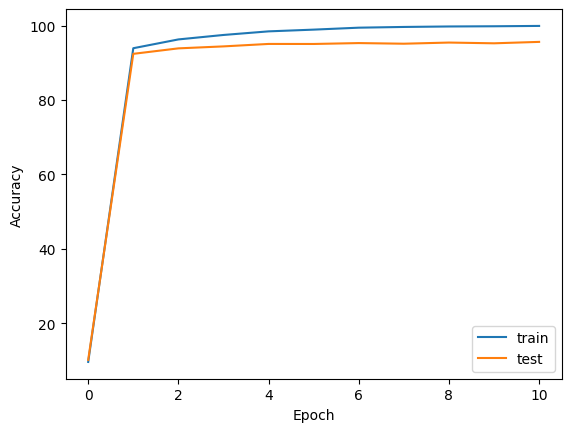

In [7]:
# 정확도(accuracy) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[0] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()

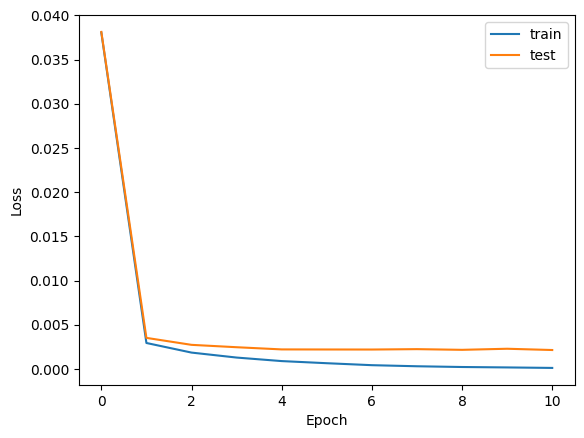

In [8]:
# 손실(loss) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[1] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.])
[ 혼동 행렬(confusion matrix) 시각화 ]


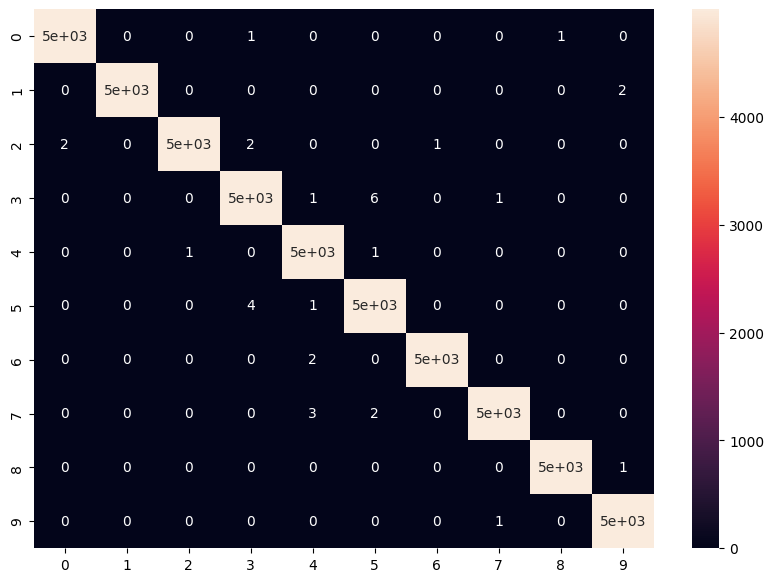

[ 각 클래스에 따른 정확도 ]
tensor([0.9996, 0.9996, 0.9990, 0.9984, 0.9996, 0.9990, 0.9996, 0.9990, 0.9998,
        0.9998])
[ 전체 평균 정확도 ]
tensor(0.9993)


In [9]:

# 혼동 행렬(Confusion Matrix) 시각화 (학습 데이터셋)
net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_ResNet18_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, train_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the wo

[ 각 클래스당 데이터 개수 ]
tensor([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.])
[ 혼동 행렬(confusion matrix) 시각화 ]


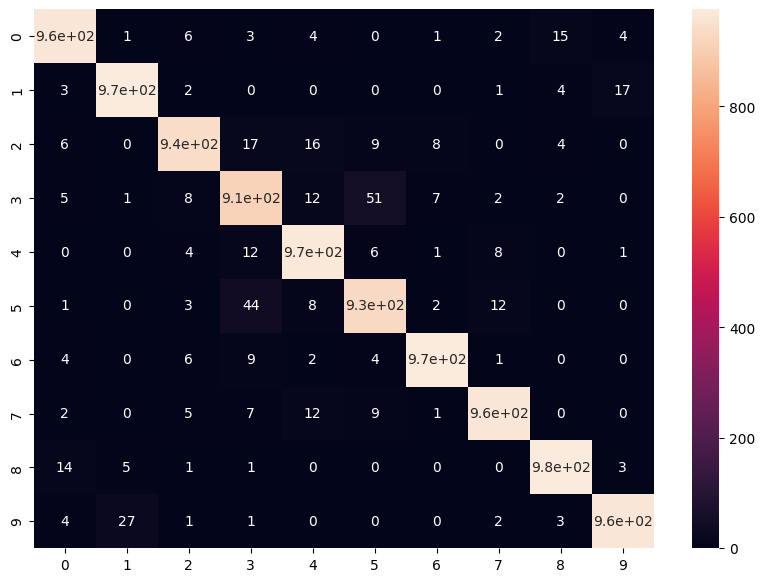

[ 각 클래스에 따른 정확도 ]
tensor([0.9640, 0.9730, 0.9400, 0.9120, 0.9680, 0.9300, 0.9740, 0.9640, 0.9760,
        0.9620])
[ 전체 평균 정확도 ]
tensor(0.9563)


In [10]:
# 혼동 행렬(Confusion Matrix) 시각화 (테스트 데이터셋)
net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_ResNet18_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, test_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

### 결과 확인 : ImageNet Pretrained ResNet50을 활용한 Transfer learning 결과 분석

In [11]:
# 학습 과정 중에 천천히 학습률(learning rate) 감소 시키기
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 5:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


net = torchvision.models.resnet50(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

epoch = 10
learning_rate = 0.01
file_name = "Transfer_Learning_ResNet50_CIFAR10.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, train_loader, "Train"))
test_result.append(evaluate(net, 0, file_name, test_loader, "Test"))

for i in range(epoch):
    adjust_learning_rate(optimizer, epoch)
    train(net, i, optimizer, criterion, train_loader)
    train_acc, train_loss = evaluate(net, i + 1, file_name, train_loader, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, test_loader, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


[ Evaluate epoch: 0 ]
Dataset: Train


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuarcy: 9.604
Average loss: 0.03756921652317047
[ Evaluate epoch: 0 ]
Dataset: Test
Accuarcy: 9.56
Average loss: 0.03770852973461151
[ Train epoch: 0 ]
Train accuarcy: 88.042
Train average loss: 0.0061231331474334
[ Evaluate epoch: 1 ]
Dataset: Train
Accuarcy: 96.744
Average loss: 0.00165942427277565
[ Evaluate epoch: 1 ]
Dataset: Test
Accuarcy: 94.84
Average loss: 0.002449513351917267
Model Saved!
[ Train epoch: 1 ]
Train accuarcy: 96.094
Train average loss: 0.0018624313644319773
[ Evaluate epoch: 2 ]
Dataset: Train
Accuarcy: 98.226
Average loss: 0.000922012712676078
[ Evaluate epoch: 2 ]
Dataset: Test
Accuarcy: 95.66
Average loss: 0.0020643572073429824
Model Saved!
[ Train epoch: 2 ]
Train accuarcy: 97.708
Train average loss: 0.0011188055015075953
[ Evaluate epoch: 3 ]
Dataset: Train
Accuarcy: 99.142
Average loss: 0.0005117434380436316
[ Evaluate epoch: 3 ]
Dataset: Test
Accuarcy: 96.08
Average loss: 0.0019341322733089329
Model Saved!
[ Train epoch: 3 ]
Train accuarcy: 98.686
Train

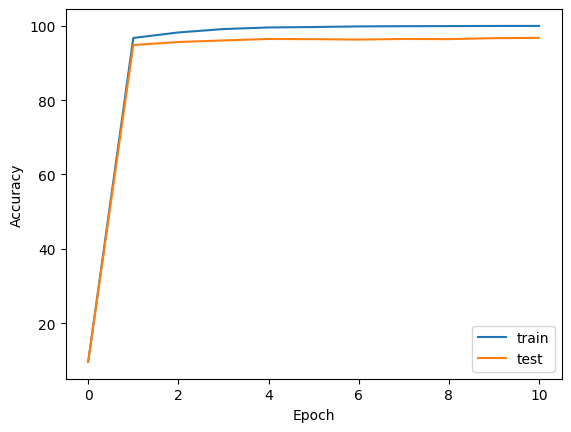

In [12]:
# 정확도(accuracy) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[0] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()

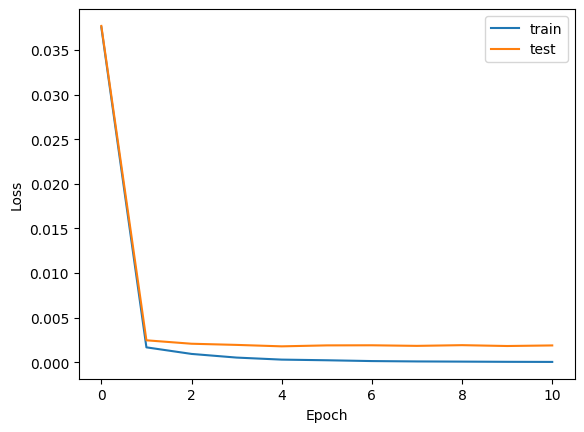

In [13]:
# 손실(loss) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[1] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.])
[ 혼동 행렬(confusion matrix) 시각화 ]


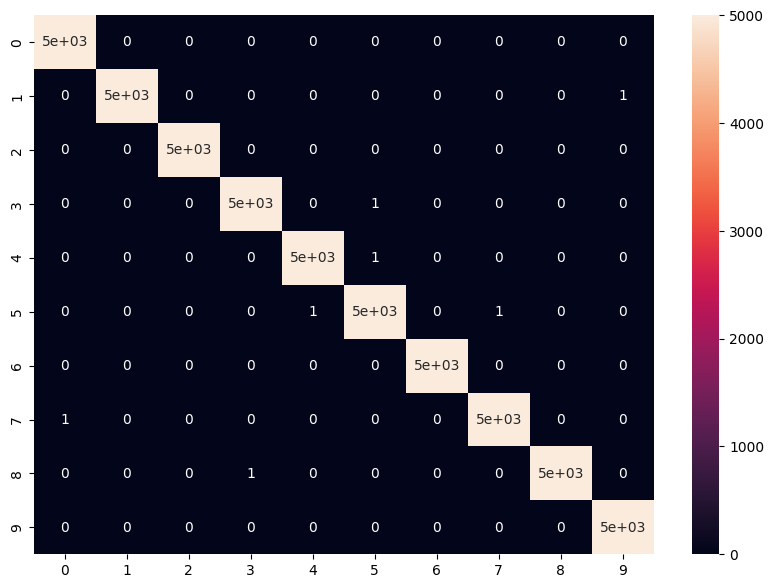

[ 각 클래스에 따른 정확도 ]
tensor([1.0000, 0.9998, 1.0000, 0.9998, 0.9998, 0.9996, 1.0000, 0.9998, 0.9998,
        1.0000])
[ 전체 평균 정확도 ]
tensor(0.9999)


In [14]:
# 혼동 행렬(Confusion Matrix) 시각화 (학습 데이터셋)
net = torchvision.models.resnet50(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_ResNet50_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, train_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the wo

[ 각 클래스당 데이터 개수 ]
tensor([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.])
[ 혼동 행렬(confusion matrix) 시각화 ]


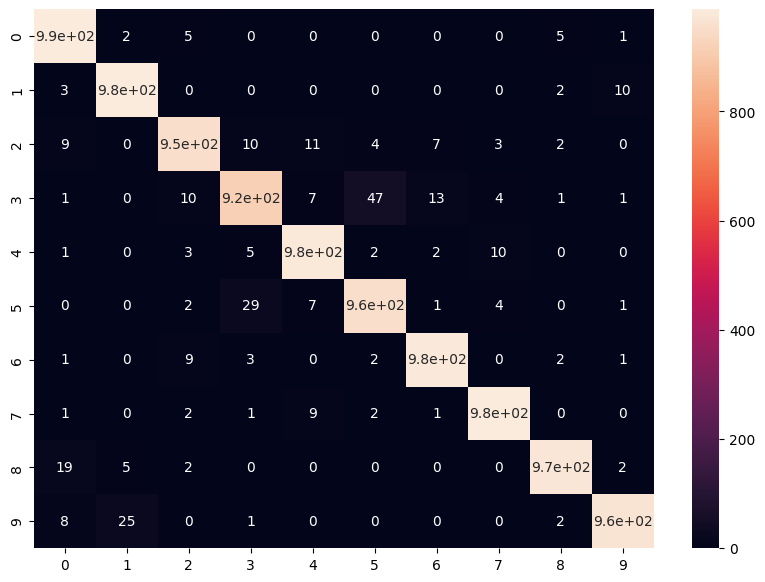

[ 각 클래스에 따른 정확도 ]
tensor([0.9870, 0.9850, 0.9540, 0.9160, 0.9770, 0.9560, 0.9820, 0.9840, 0.9720,
        0.9640])
[ 전체 평균 정확도 ]
tensor(0.9677)


In [15]:
# 혼동 행렬(Confusion Matrix) 시각화 (테스트 데이터셋)
net = torchvision.models.resnet50(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_ResNet50_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, test_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

### 결과 확인 : ImageNet Pretrained ResNet101을 활용한 Transfer learning 결과 분석

In [ ]:
# 학습 과정 중에 천천히 학습률(learning rate) 감소 시키기
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 5:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


net = torchvision.models.resnet101(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

epoch = 10
learning_rate = 0.01
file_name = "Transfer_Learning_ResNet101_CIFAR10.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, train_loader, "Train"))
test_result.append(evaluate(net, 0, file_name, test_loader, "Test"))

for i in range(epoch):
    adjust_learning_rate(optimizer, epoch)
    train(net, i, optimizer, criterion, train_loader)
    train_acc, train_loss = evaluate(net, i + 1, file_name, train_loader, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, test_loader, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

In [ ]:
# 정확도(accuracy) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[0] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()

In [ ]:
# 손실(loss) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[1] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

In [ ]:
# 혼동 행렬(Confusion Matrix) 시각화 (학습 데이터셋)
net = torchvision.models.resnet101(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_ResNet101_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, train_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

In [ ]:
# 혼동 행렬(Confusion Matrix) 시각화 (테스트 데이터셋)
net = torchvision.models.resnet101(pretrained=True)

# 마지막 레이어의 차원을 10차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 10)
net = net.to(device)

file_name = "./checkpoint/Transfer_Learning_ResNet101_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, test_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

In [ ]:
from google.colab import files

In [ ]:
files.download('./checkpoint/Transfer_Learning_ResNet18_CIFAR10.pt')

In [ ]:
files.download('./checkpoint/Transfer_Learning_ResNet50_CIFAR10.pt')

In [ ]:
files.download('./checkpoint/Transfer_Learning_ResNet101_CIFAR10.pt')